In [36]:
import tensorflow as tf;
print(tf.__version__)

2.10.0


In [37]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.10.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [38]:
from tensorflow.keras import mixed_precision
# Enable mixed precision
mixed_precision.set_global_policy('mixed_float16')
print("Mixed precision enabled")


Mixed precision enabled


1.dataset loading and  normalization

In [39]:
#Set Paths and Basic Config

# Dataset paths
train_dir = "Train"
test_dir = "Test"

# Basic params
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 123
num_classes=7  # Number of fish disease classes


In [40]:
# Create Training and Validation Datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.15,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.15,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)
class_names = train_ds.class_names
num_classes = len(class_names)

print("Class names:", class_names)
print("Number of classes:", num_classes)


Found 1748 files belonging to 7 classes.
Using 1486 files for training.
Found 1748 files belonging to 7 classes.
Using 262 files for validation.
Class names: ['Bacterial Red disease', 'Bacterial diseases - Aeromoniasis', 'Bacterial gill disease', 'Fungal diseases Saprolegniasis', 'Healthy Fish', 'Parasitic diseases', 'Viral diseases White tail disease']
Number of classes: 7


In [41]:
# Create Test Dataset

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)


Found 697 files belonging to 7 classes.


In [42]:
#Normalize and Optimize


"""normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y),
                         num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y),
                     num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y),
                       num_parallel_calls=tf.data.AUTOTUNE)
"""
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

2.Data Augmentation
(dataset is fixed in size. Augmentation artificially increases variation (rotations, flips, zoom) to make the model generalize better and avoid overfitting)

In [43]:
from tensorflow.keras import layers

# Data Augmentation layer
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),  # Flip images horizontally
    layers.RandomRotation(0.1),       # Rotate by ±10%
    layers.RandomZoom(0.1),           # Zoom by ±10%
    layers.RandomBrightness(factor=0.1)  # Adjust brightness by ±10%
],name="Augmentation_pipeline")


In [44]:
# Apply augmentation ONLY to the training dataset
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE
)
# Re-prefetch the augmented dataset
augmented_train_ds = augmented_train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

print("Augmented training dataset created.")

Augmented training dataset created.


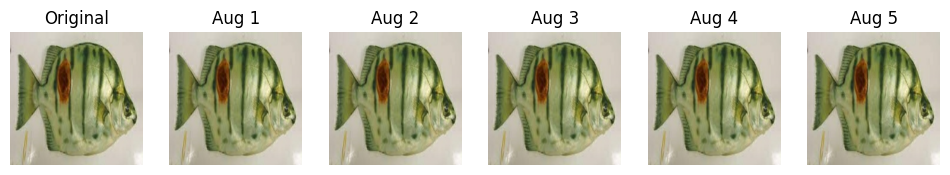

In [ ]:
"""import matplotlib.pyplot as plt
import numpy as np

# Strong augmentation for demonstration
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.3),
    tf.keras.layers.RandomZoom(0.3),
    tf.keras.layers.RandomContrast(0.5),
    tf.keras.layers.RandomTranslation(0.2, 0.2)
])

# Take one batch
for images, labels in train_ds.take(1):
    original_image = images[0].numpy().astype(np.float32)
    augmented_images = [data_augmentation(images)[0].numpy().astype(np.float32) for _ in range(5)]

# Plot original and augmented
plt.figure(figsize=(12, 6))
plt.subplot(1, 6, 1)
plt.imshow(original_image)
plt.title("Original")
plt.axis('off')

for i in range(5):
    plt.subplot(1, 6, i+2)
    plt.imshow(augmented_images[i])
    plt.title(f"Aug {i+1}")
    plt.axis('off')

plt.show()"""


In [45]:
"""from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

# 1️⃣ Load EfficientNetB0 base (pre-trained on ImageNet)
base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,          # we’ll add our own classifier
    input_shape=(224, 224, 3)   # same as your dataset images
)

base_model.trainable = False   # freeze feature extractor for now

# 2️⃣ Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
outputs = Dense(7, activation='softmax')(x)  # 7 = number of fish classes

model = Model(inputs=base_model.input, outputs=outputs)

model.summary()"""

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Rescaling, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# 1️⃣ Define the input tensor
input_tensor = Input(shape=IMG_SIZE + (3,))

# 2️⃣ CRUCIAL FIX: Add Rescaling layer INSIDE the model
# This normalizes pixel values from [0-255] to [0-1]
x = Rescaling(1./255)(input_tensor) 

# 3️⃣ Load EfficientNetB0 base (pre-trained on ImageNet)
base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,          
    input_tensor=x # Connect Rescaling output to the base model
)

base_model.trainable = False   # Freeze feature extractor for initial training

# 4️⃣ Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
# Ensure the final layer uses float32 output for numerical stability with mixed_float16
outputs = Dense(num_classes, activation='softmax', dtype='float32')(x) 

model = Model(inputs=input_tensor, outputs=outputs)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_6 (Rescaling)        (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 rescaling_7 (Rescaling)        (None, 224, 224, 3)  0           ['rescaling_6[0][0]']            
                                                                                                  
 normalization_2 (Normalization  (None, 224, 224, 3)  7          ['rescaling_7[0][0]']      

In [ ]:
"""for images, labels in train_ds.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)"""


Image batch shape: (32, 224, 224, 3)
Label batch shape: (32,)


In [46]:
"""from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)

# Train model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stop]
)
"""

from tensorflow.keras.callbacks import EarlyStopping

# Compile model (Higher LR for new classification head)
model.compile(
    optimizer=Adam(learning_rate=0.001), # Increased LR from 0.0001 to 0.001
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5, # Increased patience slightly
    restore_best_weights=True
)

# Train model (Use the augmented dataset)
history = model.fit(
    augmented_train_ds, # Use augmented data
    validation_data=val_ds,
    epochs=50, # Increased max epochs
    callbacks=[early_stop]
)


Epoch 1/50
47/47 [==============================] - 16s 145ms/step - loss: 1.9868 - accuracy: 0.1339 - val_loss: 1.9573 - val_accuracy: 0.1450
Epoch 2/50
47/47 [==============================] - 5s 90ms/step - loss: 1.9786 - accuracy: 0.1332 - val_loss: 1.9604 - val_accuracy: 0.1031
Epoch 3/50
47/47 [==============================] - 5s 92ms/step - loss: 1.9804 - accuracy: 0.1346 - val_loss: 1.9607 - val_accuracy: 0.1450
Epoch 4/50
47/47 [==============================] - 5s 87ms/step - loss: 1.9782 - accuracy: 0.1299 - val_loss: 1.9605 - val_accuracy: 0.1450
Epoch 5/50
47/47 [==============================] - 5s 89ms/step - loss: 1.9698 - accuracy: 0.1474 - val_loss: 1.9603 - val_accuracy: 0.1450
Epoch 6/50
47/47 [==============================] - 5s 89ms/step - loss: 1.9714 - accuracy: 0.1299 - val_loss: 1.9578 - val_accuracy: 0.1450


In [ ]:
"""# Step 7 — Fine-tuning EfficientNetB0

# 1️⃣ Unfreeze top layers of EfficientNet for fine-tuning
base_model.trainable = True

# Optionally, freeze the first few layers (to prevent overfitting)
for layer in base_model.layers[:150]:
    layer.trainable = False

# 2️⃣ Recompile with a lower learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # smaller LR for fine-tuning
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 3️⃣ Continue training
fine_tune_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,          # you can increase to 15–20 later
    callbacks=[early_stop]
)
"""

# Step 7 — Fine-tuning EfficientNetB0

# 1️⃣ Unfreeze top layers of EfficientNet for fine-tuning
base_model.trainable = True

# Freeze the first 1/3 of the base model layers (to keep very generic features frozen)
# EfficientNetB0 has ~235 layers, so freezing ~78 layers is a good starting point
num_frozen_layers = len(base_model.layers) // 3
for layer in base_model.layers[:num_frozen_layers]:
    layer.trainable = False

# 2️⃣ Recompile with a very low learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Keep very small LR for fine-tuning
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 3️⃣ Continue training (Use augmented data)
fine_tune_history = model.fit(
    augmented_train_ds, # Use augmented data
    validation_data=val_ds,
    epochs=20,          
    callbacks=[early_stop]
)

Epoch 1/10
47/47 [==============================] - 17s 154ms/step - loss: 2.0077 - accuracy: 0.1406 - val_loss: 1.9500 - val_accuracy: 0.1374
Epoch 2/10
47/47 [==============================] - 5s 106ms/step - loss: 1.9819 - accuracy: 0.1514 - val_loss: 1.9542 - val_accuracy: 0.1374
Epoch 3/10
47/47 [==============================] - 5s 107ms/step - loss: 1.9589 - accuracy: 0.1528 - val_loss: 1.9580 - val_accuracy: 0.1450
Epoch 4/10
47/47 [==============================] - 5s 106ms/step - loss: 1.9691 - accuracy: 0.1514 - val_loss: 1.9622 - val_accuracy: 0.1450
Epoch 5/10
47/47 [==============================] - 5s 106ms/step - loss: 1.9609 - accuracy: 0.1662 - val_loss: 1.9638 - val_accuracy: 0.1450
Epoch 6/10
47/47 [==============================] - 5s 111ms/step - loss: 1.9390 - accuracy: 0.1931 - val_loss: 1.9630 - val_accuracy: 0.1450


In [ ]:
"""from tensorflow.keras import layers

# 1️⃣ Add data augmentation layer
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomBrightness(factor=0.1)
])

# 2️⃣ Apply augmentation to your train dataset only
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

# 3️⃣ Retrain the same model on augmented data
fine_tune_aug_history = model.fit(
    augmented_train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stop]
)"""


Epoch 1/10
47/47 [==============================] - 7s 120ms/step - loss: 2.0000 - accuracy: 0.1393 - val_loss: 1.9644 - val_accuracy: 0.1450
Epoch 2/10
47/47 [==============================] - 7s 119ms/step - loss: 2.0045 - accuracy: 0.1299 - val_loss: 1.9659 - val_accuracy: 0.1450
Epoch 3/10
47/47 [==============================] - 7s 118ms/step - loss: 1.9883 - accuracy: 0.1312 - val_loss: 1.9632 - val_accuracy: 0.1450
Epoch 4/10
47/47 [==============================] - 7s 120ms/step - loss: 1.9947 - accuracy: 0.1339 - val_loss: 1.9621 - val_accuracy: 0.1450


In [ ]:
"""# 1️⃣ Unfreeze part of the EfficientNet base
base_model.trainable = True

# Optionally freeze the first few layers (they capture very generic features)
for layer in base_model.layers[:150]:
    layer.trainable = False

# 2️⃣ Recompile with a lower learning rate
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 3️⃣ Continue training
fine_tune_history = model.fit(
    augmented_train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop]
)"""


Epoch 1/10
47/47 [==============================] - 18s 157ms/step - loss: 1.9889 - accuracy: 0.1474 - val_loss: 1.9655 - val_accuracy: 0.1450
Epoch 2/10
47/47 [==============================] - 7s 120ms/step - loss: 1.9945 - accuracy: 0.1312 - val_loss: 1.9636 - val_accuracy: 0.1450
Epoch 3/10
47/47 [==============================] - 7s 117ms/step - loss: 1.9763 - accuracy: 0.1413 - val_loss: 1.9647 - val_accuracy: 0.1450
Epoch 4/10
47/47 [==============================] - 6s 117ms/step - loss: 1.9720 - accuracy: 0.1608 - val_loss: 1.9586 - val_accuracy: 0.1450
